In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
L = 1
K = 200
C = 1000
rho = 3000
l = K/(C*rho)
N_t = 10000
delta_x = 0.01
x = np.linspace(-L/2, L/2, int(L/delta_x))
x = np.pad(x, (1, 1), 'constant', constant_values=0)
T_0 = [np.sin(np.pi*x_i/L) for x_i in x]

In [45]:
def FTCS_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    for t in range(N_t):
        T_new = np.zeros(int(L/delta_x)+2)
        T_old = T[-1]
        for i in range(1, T_new.shape[0]-1):
            T_new[i] = (1-2*a)*T_old[i]+a*(T_old[i-1]+T_old[i+1])
        T.append(T_new)
    return T

T = FTCS_rod()

In [8]:
import matplotlib; matplotlib.use("TkAgg")
import matplotlib.animation as animation

fig, ax = plt.subplots()

line, = ax.plot(x, T_0)
legend = plt.legend()

def animate(i):
    line.set_ydata(T[i])
    legend.set_title("Time step: {}".format(i))
    return line, legend

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig=fig, func=animate, frames=N_t, init_func=init, interval=25, blit=True)

plt.xlabel("x")
plt.ylabel("T")
plt.title("Temperature development in the rod")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [23]:
def T_exact(t):
    list_T_exact = np.zeros(len(x))
    f2 = np.exp(-(K*t*np.pi**2)/(C*rho*L**2))
    for i, x_i in enumerate(x):
        f1 = np.sin(np.pi*x_i/L)
        list_T_exact[i] = f1*f2
    list_T_exact = np.array(list_T_exact)
    return list_T_exact

def error(T, t):
    return np.sum(np.abs(T[t]-T_exact(t)))

# Study the behaviour of ϵ(t = 100) varying ∆t between 0.001
#and 0.7 while keeping ∆x fixed. What happens? Explain your finding.

In [46]:
list_delta_t = np.linspace(0.001,0.7, 100)
def errors_for_delta_t(scheme):
    list_errors = []
    for dt in tqdm(list_delta_t):
        T_dt = scheme(dt)
        err = error(T_dt, 100)
        list_errors.append(err)
    return list_errors

list_errors_FTCS = errors_for_delta_t(FTCS_rod)

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Text(0.5, 0, '$\\Delta t$')

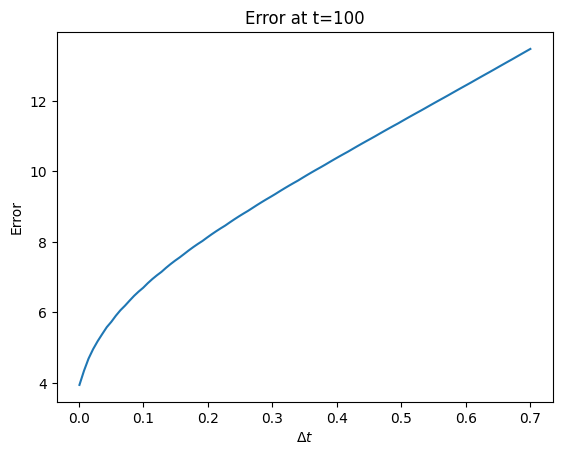

In [33]:
%matplotlib inline
plt.plot(list_delta_t, list_errors_FTCS)
plt.title("Error at t=100")
plt.ylabel("Error")
plt.xlabel("$\Delta t$")

In [37]:
def Euler_backward_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    A = np.eye(len(x))
    for i in range(A.shape[0]-1):
        A[i+1, i] = -a
        A[i, i+1] = -a
    for i in range(1, A.shape[0]-1):
        A[i,i] += 2*a
    A_inv = np.linalg.inv(A)
    for t in range(N_t):
        T_old = T[-1]
        T_new = np.matmul(A_inv, T_old)
        T.append(T_new)
    return T

T_euler_backward = Euler_backward_rod()

In [39]:
def Crank_Nicolson_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    dim = len(x)
    A = np.eye(dim)
    B = np.eye(dim)
    for i in range(1, dim-1):
        A[i,i] += 2*a
        B[i,i] -= 2*a
        A[i, i-1] = -a
        A[i, i+1] = -a
        B[i, i-1] = a
        B[i, i+1] = a
    A_inv = np.linalg.inv(A)
    for t in range(N_t):
        T_old = T[-1]
        T_new_p = np.matmul(B, T_old)
        T_new = np.matmul(A_inv, T_new_p)
        T.append(T_new)
    return T

T_Crank_Nicolson = Crank_Nicolson_rod()

In [42]:
def DuFort_Frankel_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    c = (1-a)/(1+a)
    d = a/(1+a)
    for t in range(N_t):
        T_new = np.zeros(int(L/delta_x)+2)
        T_old = T[-1]
        T_before = T[-2] if t>1 else np.zeros(int(L/delta_x)+2)
        for i in range(1, T_new.shape[0]-1):
            T_new[i] = c*T_before[i] + d*(T_old[i-1]+T_old[i+1])
        T.append(T_new)
    return T

T_DuFort_Frankel = DuFort_Frankel_rod()

In [47]:
list_errors_Euler_backward = errors_for_delta_t(Euler_backward_rod)
list_errors_Crank_nicolson = errors_for_delta_t(Crank_Nicolson_rod)
list_errors_DuFort_Frankel = errors_for_delta_t(DuFort_Frankel_rod)

 29%|██▉       | 29/100 [00:10<00:24,  2.85it/s]C:\Users\corin\AppData\Local\Temp\ipykernel_8580\803799785.py:13: RuntimeWarning: overflow encountered in matmul
  T_new = np.matmul(A_inv, T_old)
C:\Users\corin\AppData\Local\Temp\ipykernel_8580\803799785.py:13: RuntimeWarning: invalid value encountered in matmul
  T_new = np.matmul(A_inv, T_old)
100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Text(0.5, 0, '$\\Delta t$')

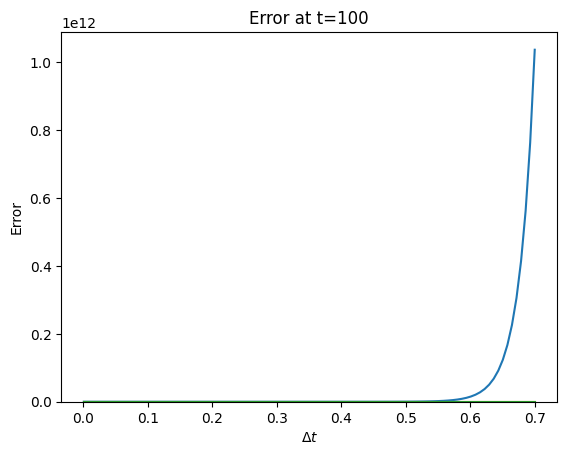

In [50]:
%matplotlib inline
plt.plot(list_delta_t, list_errors_Euler_backward)
plt.plot(list_delta_t, list_errors_Crank_nicolson)
plt.plot(list_delta_t, list_errors_DuFort_Frankel)
plt.title("Error at t=100")
plt.ylabel("Error")
plt.ylim(0.1)
plt.xlabel("$\Delta t$")